In [2]:
import torch
from diffusers import StableDiffusion3Pipeline, DPMSolverMultistepScheduler
from attention_map_diffusers import (
    attn_maps,
    init_pipeline,
    save_attention_maps
)


model_id = "stabilityai/stable-diffusion-3.5-medium"

pipe = StableDiffusion3Pipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe = init_pipeline(pipe)

Loading pipeline components...:   0%|          | 0/9 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


  0%|          | 0/28 [00:00<?, ?it/s]

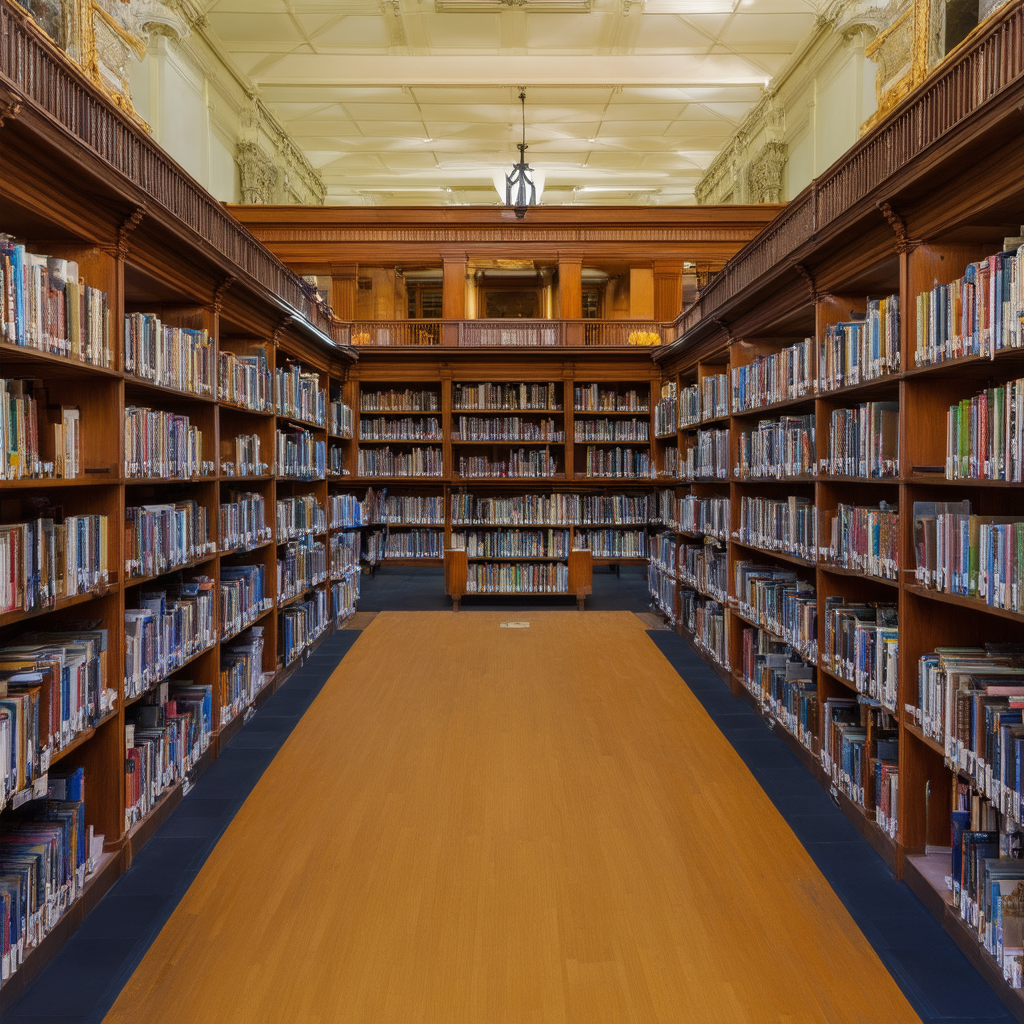

In [9]:
pipe = pipe.to("cuda") 

prompt = "a photo of a library"
negative_prompt = "book"
image = pipe(
            prompt,
            negative_prompt=negative_prompt,
        ).images[0]  
    
image

In [24]:
import os
import torch.nn.functional as F

token_ids =pipe.tokenizer([negative_prompt])['input_ids']
token_ids = token_ids if token_ids and isinstance(token_ids[0], list) else [token_ids]
total_tokens = [pipe.tokenizer.convert_ids_to_tokens(token_id) for token_id in token_ids]

total_attn_map = list(list(attn_maps.values())[0].values())[0].sum(1)
total_attn_map = total_attn_map.chunk(2)[0]  # (batch, height, width, attn_dim)
total_attn_map = total_attn_map.permute(0, 3, 1, 2)
total_attn_map = torch.zeros_like(total_attn_map)
total_attn_map_shape = total_attn_map.shape[-2:]

layers = list(attn_maps.values())[10]
maps = []
for layer, attn_map in layers.items(): 
    layer_dir = os.path.join(f'{layer}')
    
    attn_map = attn_map.sum(1).squeeze(1).permute(0, 3, 1, 2)
    attn_map = attn_map.chunk(2)[0]
    
    resized_attn_map = F.interpolate(attn_map, size=total_attn_map_shape, mode='bilinear', align_corners=False)
    total_attn_map += resized_attn_map
    
    for batch, (tokens, attn) in enumerate(zip(total_tokens, attn_map)):
        batch_dir = os.path.join(layer_dir, f'batch-{batch}')
        maps.append(attn_map)

In [18]:
total_attn_map.shape

torch.Size([1, 333, 64, 64])

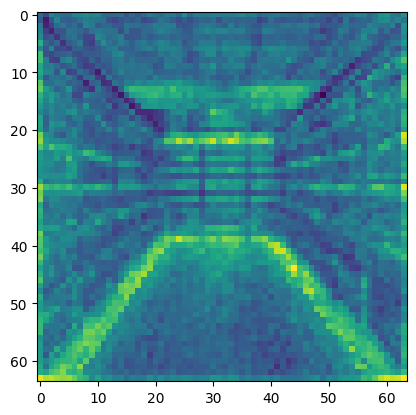

In [28]:
import pylab 
pylab.imshow(resized_attn_map[:,:1].detach().cpu().numpy().mean(0)[:2].mean(0)) 

In [ ]:
save_attention_maps(attn_maps, pipe.tokenizer, [prompt], base_dir='attn_maps', unconditional=True)
